In [43]:
import math
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax.scipy.linalg import solve

#Ensure Jax runs smoothly
jax.config.update("jax_enable_x64",True)


In [44]:
#Define the Initial conds and functions
#define Symbolic function q
def q_xy(x,y,Lx,Ly,La):
    return (2/(Lx**2*Ly))* (y*(1-y/Ly)) *(1+La**2/Ly**2)+ 2*La/(Lx*Ly**2)* ((1-(2*(x-(La/Ly)*y)))/Lx)* (1-2*(y/Ly))+ 2/(Lx*Ly**2)* ((x-(La/Ly)*y))* (1-(x-(La/Ly)*y)/Lx)

def q_zn(z,n,Lz,Ln,La):
    return (2*La*((2*n)/Ln - 1)*(2*z + 2*La*n - (2*La*n)/Ln - 1))/(Ln**2*(Lz + La*Ln)**2) - (2*((z + La*n - (La*n)/Ln)/(Lz + La*Ln) - 1)*(z + La*n - (La*n)/Ln))/(Ln**2*(Lz + La*Ln)) - (2*n*(La**2/Ln**2 + 1)*(n/Ln - 1))/(Ln*(Lz + La*Ln)**2)

def q(z,n,Lz,Ln,La):
    Lx=Lz; Ly=Ln
    y=n
    x=z+La/Ly*n
    q=2/(Lx**2*Ly)*(y*(1-y/Ly))*(1+La**2/Ly**2)
    q=q+2*La/(Lx*Ly**2)*(1-2*(x-La/Ly*y)/Lx)*(1-2*y/Ly)
    q=q+2/(Lx*Ly**2)*((x-La/Ly*y)*(1-(x-La/Ly*y)/Lx))

    #q=2/(Lx**2*Ly)*n*(1-n/Ly)*(1+La**2/Ly**2)+2*La/(Lx*Ly**2)*(1-2*z/Lx)*(1-2*n/Ly)+2*z/(Lx**2*Ly)*(1-z/Lx)
    return q
    
#Initial Conditions
Lx=2.0; Ly=1.; La=0.5
Lz=Lx; Ln=Ly
Nx=10 ; Ny=5
T0=0; k=1


In [45]:
#Cordinate Transform functions
def transform(x,Ny,dy,La,Ln):
    #Transforms x matrix to a xi cordnites (z)
    z=x
    for j in range(Ny+1):
        n=dy*j
        z[j,:]=x[j,:]-La/Ln*n

    return z


In [46]:
#Plotting and Printing
#Create a Contour plot
def plot_contour(x,y,val):
    #input:
    #xs,ys: The x and y value arrays 1D arrays
    #Z: The function value, 1D Array
    #Cords: Cordniates of the nodes
    X, Y = np.meshgrid(x, y)
    #Create Z to be 2D
    Z=np.zeros((len(y),len(x)))
    c=0
    for i in range(len(y)):
        for j in range(len(x)):
            Z[i,j]=val[c]
            c+=1
    plt.contourf(X, Y, Z,levels=20)
    
    plt.xlabel('Xi-axis')
    plt.ylabel('Eta-axis')
    plt.colorbar(label='Temp')
    plt.title('Contour Plot of the Temp')

In [47]:
#Create the Matrix A for the Stencil
def Stencil(Nx,Ny,dx,dy):
    #Input:
    #Nx, Ny: Number of nodes in the x and y direction
    #dx,dy: The step amount in the x and y direction

    #Output:
    #A: The stencil Matrix A for the central diff 2nd Derivative

    #Create a Matrix with 1 on the whole diagnal as the starting point
    #Create the format for the Matrix row
    LHS=np.arange(0,(Ny+1)*(Nx+1)-(Nx+1), Nx+1)
    RHS=np.arange(Nx+1,(Ny+1)*(Nx+1), Nx+1)
    # print("LHS=",LHS,"RHS=",RHS)
    node=0 #the node number and keeps track for the stencil building
    #Create Matrix A
    A = jnp.diag(np.ones((Ny+1)*(Nx+1)))
    for i in range((Ny+1)*(Nx+1)):
        for j in range((Ny+1)*(Nx+1)):
            #check if on the diagnal and build off that
            if(i==j):
                #check to make sure not on the boundary of the mesh
                if(node>Nx+1 and node<((Nx+1)*(Ny+1)-(Nx+1)-1) and node not in LHS and node not in RHS):
                    # print("Node",node,"i",i,"j",j)
                    #uxx/uyy
                    #diagonal
                    A=A.at[(i,j)].set((-2/dx**2)*(1+La**2/Ly**2)-(2/dy**2))
                    #off diagonal upper and lower
                    A=A.at[(i,j-1)].set((1/dx**2)*(1+(La**2/Ly**2)))
                    A=A.at[(i,j+1)].set((1/dx**2)*(1+(La**2/Ly**2)))

                    #unn
                    #Far off diagonal upper and lower (This repersents j+/-1 in the stencil)
                    A=A.at[(i,j-(Nx+1))].set((1/dy**2))
                    A=A.at[(i,j+(Nx+1))].set((1/dy**2))

                    #uxy
                    A=A.at[(i,j+(Nx+1)+1)].set((-1/(2*dx*dy))*(La/Ly))
                    A=A.at[(i,j+(Nx+1)-1)].set((1/(2*dx*dy))*(La/Ly))
                    A=A.at[(i,j-(Nx+1)+1)].set((1/(2*dx*dy))*(La/Ly))
                    A=A.at[(i,j-(Nx+1)-1)].set((-1/(2*dx*dy))*(La/Ly))

                node+=1


    return A

def Stencil_diagOnly(Nx,Ny,dx,dy):
    #Input:
    #Nx, Ny: Number of nodes in the x and y direction
    #dx,dy: The step amount in the x and y direction

    #Output:
    #A: The stencil Matrix A for the central diff 2nd Derivative

    #Create a Matrix with 1 on the whole diagnal as the starting point
    #Create the format for the Matrix row
    LHS=np.arange(0,(Ny+1)*(Nx+1)-(Nx+1), Nx+1)
    RHS=np.arange(Nx+1,(Ny+1)*(Nx+1), Nx+1)
    # print("LHS=",LHS,"RHS=",RHS)
    node=0 #the node number and keeps track for the stencil building
    #Create Matrix A
    D = np.diag(np.ones((Ny+1)*(Nx+1)))
    for i in range((Ny+1)*(Nx+1)):
        for j in range((Ny+1)*(Nx+1)):
            #check if on the diagnal and build off that
            if(i==j):
                #check to make sure not on the boundary of the mesh
                if(node>Nx+1 and node<((Nx+1)*(Ny+1)-(Nx+1)-1) and node not in LHS and node not in RHS):
                    # print("Node",node,"i",i,"j",j)
                    #uxx/uyy
                    #diagonal
                    D[i,j]=(-2/dx**2)*(1+La**2/Ly**2)-(2/dy**2)
 
                node+=1


    return D

In [48]:
#part ii
#Show Stencil A
dz=Lz/Nx; dn=Ln/Ny
A=Stencil(Nx,Ny,dz,dn)
#print(A[13,:])

In [49]:
def Temp_solver(T0,La,Li,Lj,k,Ni,Nj):
    #Input:
    #T0: The Intial Value of the Boundary Condition
    #La, Lx, Ly: The measurement lengths in the various directions, used for q eqn
    #k: kappa, used in q eqn for heat transfer
    #Ni, Nj: Number of nodes in the i and j direction
    #di,dj: The step amount in the i and j direction

    #Output:
    #T: Nodal Temp values
    #ij: i,j cordinates for each node 

    #find spacing of the Mesh
    di=Li/Ni; dj=Lj/Nj
    A=Stencil(Ni,Nj,di,dj)

    # Create the vector representing the heat source (modify q(x) as needed)
    xs=jnp.linspace(0,Li,Ni+1)
    ys=jnp.linspace(0,Lj,Nj+1)
    b=jnp.zeros((Ni+1)*(Nj+1))
    
    node=1
    # node_cords=np.zeros(((Ni+1)*(Nj+1),2))
    LHS=np.arange(1,(Ni+1)*(Nj+1), Ni+1)
    RHS=np.arange(Ni+1,(Ni+1)*(Nj+1), Ni+1)
    # print("LHS=",LHS,"RHS=",RHS)
    for j in range(len(ys)):
        for i in range(len(xs)):      
            b=b.at[node-1].set(q(xs[i],ys[j],Li,Lj,La)/-k)
            # print("i=",xs[i],"j=",ys[j])
            if(node<Ni+1 or node>(Ni+1)*(Nj+1)-(Ni+1) or node in LHS or node in RHS):
                b=b.at[node-1].set(T0)
            # node_cords[node-1]=xs[i],ys[j]
            
            node+=1
    T=jax.numpy.linalg.solve(A,b)
    return T, 0


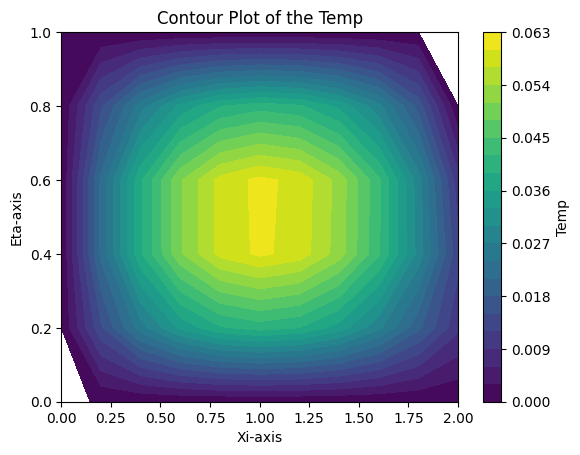

In [50]:
#part iii
#Solve the problem directly
T,cords=Temp_solver(T0,La,Lz,Ln,k,Nx,Ny)

# print(xs,ys)
# print(len(xs),len(ys))
# print(T)
# print(len(T))
#Transform the cordinates back to x,y
# for i in range(len(cords)):
#     cords[i]=transform(cords[i],La,Ly)
zs=jnp.linspace(0,Lz,Nx+1)
ns=jnp.linspace(0,Ln,Ny+1)

plt.figure(0)
plot_contour(zs,ns,T)
# plt.show
plt.savefig("prob_iii.svg")
# print(T)

In [51]:
#useful functions for the iterative solver
def residual(u,uold):
    #Inputs:
    #u: Initial guess
    #q: source heat fnc
    #k: kappa, thermal conductivity
    #dx,dy: Grid spacing
    #La, Ly: Length of grid used in stencil
    #Nx: Number of grid spacings in X directions (used for stencil)

    #Outputs:
    #r: Residual


    r=abs(u-uold)

    return r

def residual_real(u,q,dx,La,Ly):
    cons_mid=-2/(dx**2)*(1+La**2/Ly**2)-2/dn**2 #mid point scheme
    cons_LR=1/(dx**2)*(1+La**2/Ly**2) #Left right scheme
    cons_UD=1/dn**2 #up down scheme
    cons_diag=La/(2*Ly*dx*dn)
    r=np.zeros(len(u))
    for i in range((Nx+2),len(u)-Nx-2):
        node_vals=(u[i-1]+u[i+1])*cons_LR+(u[i+(Nx+1)]+u[i-(Nx+1)])*cons_UD+u[i]*cons_mid+cons_diag*(-u[i+(Nx+1)+1]+u[i+(Nx+1)-1]+u[i-(Nx+1)+1]-u[i-(Nx+1)-1])
        #divide by mid const and add q
        r[i]=-(node_vals-1/k*q[i])
    return r

#Computer the norm
def norm(v):
    #input:
    #r: vector to compute norm of

    #output:
    #returns the norm of the vector

    return np.linalg.norm(v)/np.sqrt((len(v)))


In [ ]:
#smoother functions
#Jacobi Smoother
def jacobiIteration(u,q,dx,La,Ly,w):
    #Inputs:
    #u: Initial guess
    #q: source heat fnc
    #k: kappa, thermal conductivity
    #dx,dy: Grid spacing
    #La, Ly: Length of grid used in stencil
    #Nx: Number of grid spacings in X directions (used for stencil)

    #output:
    #unew: returns the new u vector

    ##calculates the multipliers for the stencil
    cons_mid=-2/(dx**2)*(1+La**2/Ly**2)-2/dn**2 #mid point scheme
    cons_LR=1/(dx**2)*(1+La**2/Ly**2) #Left right scheme
    cons_UD=1/dn**2 #up down scheme
    cons_diag=La/(2*Ly*dx*dn)
    uNew = np.copy(u)
    LHS=np.arange(0,len(u), Nx+1)
    RHS=np.arange(Nx+1,len(u)+1, Nx+1)
    
    for i in range((Nx+2),len(u)-Nx-2):
        if(i not in LHS and i not in RHS):
            #first get node values
            node_vals=(u[i-1]+u[i+1])*cons_LR+(u[i+(Nx+1)]+u[i-(Nx+1)])*cons_UD+cons_diag*(-u[i+(Nx+1)+1]+u[i+(Nx+1)-1]+u[i-(Nx+1)+1]-u[i-(Nx+1)-1])
            #divide by mid const and add q
            uNew[i]=-(node_vals-1/k*q[i])/(cons_mid)
            
    uNew=uNew*w+(1-w)*u       
    
    return uNew

In [53]:
#Gauss Siedal Smoother
def GS_Iteration(u,q,dx,La,Ly,w):
    #Inputs:
    #u: Initial guess
    #q: source heat fnc
    #k: kappa, thermal conductivity
    #dx,dy: Grid spacing
    #La, Ly: Length of grid used in stencil
    #Nx: Number of grid spacings in X directions (used for stencil)

    #output:
    #unew: returns the new u vector

    ##calculates the multipliers for the stencil
    cons_mid=-2/(dx**2)*(1+La**2/Ly**2)-2/dn**2 #mid point scheme
    cons_LR=1/(dx**2)*(1+La**2/Ly**2) #Left right scheme
    cons_UD=1/dn**2 #up down scheme
    cons_diag=La/(2*Ly*dx*dn)
    uNew = np.copy(u)
    LHS=np.arange(0,len(u), Nx+1)
    RHS=np.arange(Nx+1,len(u)+1, Nx+1)

    for i in range(Nx+2,len(u)-Nx-2):
        if(i not in LHS and i not in RHS):

            #if statment to do the red/black scheme
            if(i%2==0):
            #first get node values
                node_vals=(uNew[i-1]+uNew[i+1])*cons_LR+(uNew[i+(Nx+1)]+uNew[i-(Nx+1)])*cons_UD+cons_diag*(-uNew[i+(Nx+1)+1]+uNew[i+(Nx+1)-1]+uNew[i-(Nx+1)+1]-uNew[i-(Nx+1)-1])
            else:
                node_vals=(u[i-1]+u[i+1])*cons_LR+(u[i+(Nx+1)]+u[i-(Nx+1)])*cons_UD+cons_diag*(-u[i+(Nx+1)+1]+u[i+(Nx+1)-1]+u[i-(Nx+1)+1]-u[i-(Nx+1)-1])
            #divide by mid const and add q
            uNew[i]=-(node_vals-1/k*q[i])/(cons_mid)

            uNew[i]=uNew[i]*w+(1-w)*u[i]  
    
    return uNew

In [58]:
#Iterative Solver
def iterativeSolve(u,q,dx,dy,La,Ly,smoother,w,tol,maxIter):
    #Inputs:
    #u: Initial guess
    #w: Relaxtion factor
    #q: source heat fnc
    #k: kappa, thermal conductivity
    #dx,dy: Grid spacing
    #La, Ly: Length of grid used in stencil
    #Nx: Number of grid spacings in X directions (used for stencil)
    #tol: Tolerance for the residual
    #matIter: Max amount of iterations

    #Outputs:
    #T: Solution Vector
    resNormHistory = []
    iterationTimes = []
    printFrequency = max(1, maxIter // 10)
    for i in range(maxIter):
        uold=u

        u=smoother(u,q,dx,La,Ly,w)
        #Computes the residual
        #r=residual(u,uold)
        r=residual_real(u,q,dx,La,Ly)
        r_norm=np.linalg.norm(r)
        
        # Print some information and save the residual norm and the current time
        resNormHistory+=[r_norm]
        iterationTimes+=[i]
        if i % printFrequency == 0:
            print(f"Iteration {i}: Res norm = {r_norm:.2e}")
        #check for convergence
        if r_norm < tol or r_norm > 1e10 or np.isnan(r_norm):
            break
        #apply smoother if not converged
        

    return u,resNormHistory,iterationTimes 

In [55]:
#part iv

#setup the problem
#create source term vector
qVec = np.zeros((Nx+1)*(Ny+1))  # Source term
node=1
LHS=np.arange(1,(Nx)*(Ny+1), Nx+1)
RHS=np.arange(Nx+1,(Nx+1)*(Ny+1), Nx+1)
for j in range(len(ns)):
    for i in range(len(zs)):      
        qVec[node-1]=q(zs[i],ns[j],Lx,Ly,La)/-k
        if(node<Nx+1 or node>(Nx+1)*(Ny+1)-(Nx+1) or node in LHS or node in RHS):
            qVec[node-1]=(T0)
        node+=1
u = qVec # Initial guess


Iteration 0: Res norm = 6.93e+01
Iteration 100: Res norm = 1.69e+00
Iteration 200: Res norm = 1.69e+00
Iteration 300: Res norm = 1.72e+00
Iteration 400: Res norm = 1.73e+00
Iteration 500: Res norm = 1.73e+00
Iteration 600: Res norm = 1.73e+00
Iteration 700: Res norm = 1.73e+00
Iteration 800: Res norm = 1.73e+00
Iteration 900: Res norm = 1.73e+00
Iteration 0: Res norm = 5.89e+01
Iteration 100: Res norm = 1.70e+00
Iteration 200: Res norm = 1.73e+00
Iteration 300: Res norm = 1.73e+00
Iteration 400: Res norm = 1.73e+00
Iteration 500: Res norm = 1.73e+00
Iteration 600: Res norm = 1.73e+00
Iteration 700: Res norm = 1.73e+00
Iteration 800: Res norm = 1.73e+00
Iteration 900: Res norm = 1.73e+00
Iteration 0: Res norm = 4.94e+01
Iteration 100: Res norm = 1.73e+00
Iteration 200: Res norm = 1.73e+00
Iteration 300: Res norm = 1.73e+00
Iteration 400: Res norm = 1.73e+00
Iteration 500: Res norm = 1.73e+00
Iteration 600: Res norm = 1.73e+00
Iteration 700: Res norm = 1.73e+00
Iteration 800: Res norm = 

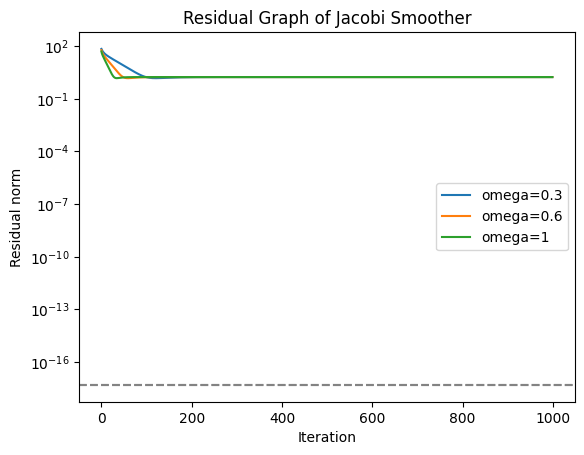

In [59]:
# Solve the system using Jacobi
tol = 5e-18
w=1
# uJacobi, resNormHistoryJacobi, iterationTimesJacobi = iterativeSolve(u,qVec,dz,dn,La,Ly,jacobiIteration,w,tol,900)
# plt.figure(2)
# plot_contour(zs,ns,uJacobi)
# print(uJacobi)

plt.figure(3)
w=[0.3,0.6,1]
labels=["omega=0.3","omega=0.6","omega=1"]
for i in range(3):
    uJacobi, resNormHistoryJacobi, iterationTimesJacobi = iterativeSolve(u,qVec,dz,dn,La,Ly,jacobiIteration,w[i],tol,1000)
    plt.xlabel("Iteration")
    plt.ylabel("Residual norm")
    plt.yscale("log")
    plt.title("Residual Graph of Jacobi Smoother")
    plt.plot(resNormHistoryJacobi, clip_on=False, label=labels[i])
    # ax.plot(resNormHistoryGS, color=niceColors[1], clip_on=False, label="Gauss-Seidel")
    plt.axhline(tol, color="gray", linestyle="--", clip_on=False, alpha=0.7)
    plt.legend()
plt.savefig("problem_iv_Jacobi.svg")

Iteration 0: Res norm = 9.55e-02
Iteration 90: Res norm = 8.80e-08
Iteration 180: Res norm = 1.44e-13
Iteration 0: Res norm = 4.54e-02
Iteration 50: Res norm = 1.06e-03
Iteration 100: Res norm = 4.90e-05
Iteration 150: Res norm = 2.27e-06
Iteration 200: Res norm = 1.05e-07
Iteration 250: Res norm = 4.85e-09
Iteration 300: Res norm = 2.24e-10
Iteration 350: Res norm = 1.04e-11
Iteration 400: Res norm = 4.80e-13
Iteration 450: Res norm = 2.22e-14
Iteration 0: Res norm = 9.55e-02
Iteration 50: Res norm = 3.28e-05
Iteration 100: Res norm = 2.00e-08
Iteration 150: Res norm = 1.22e-11
Iteration 200: Res norm = 7.46e-15
Iteration 250: Res norm = 6.27e-18
Iteration 0: Res norm = 1.51e-01
Iteration 50: Res norm = 2.88e-02
Iteration 100: Res norm = 1.08e-01
Iteration 150: Res norm = 4.29e-01
Iteration 200: Res norm = 1.69e+00
Iteration 250: Res norm = 6.78e+00
Iteration 300: Res norm = 2.67e+01
Iteration 350: Res norm = 1.06e+02
Iteration 400: Res norm = 4.23e+02
Iteration 450: Res norm = 1.66e+

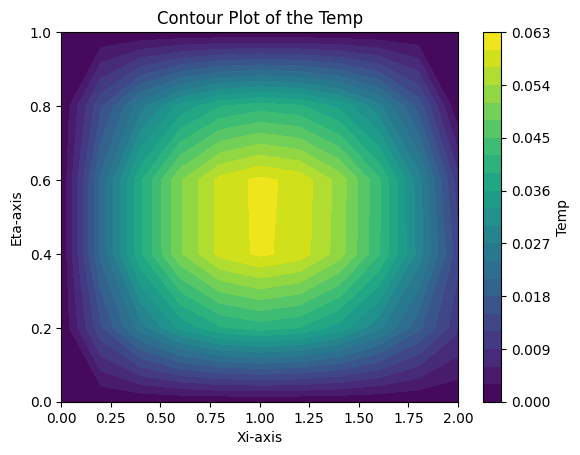

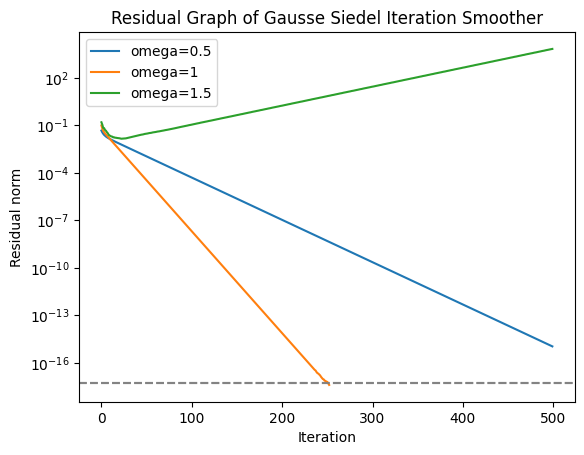

In [34]:

uJacobi, resNormHistoryJacobi, iterationTimesJacobi = iterativeSolve(u,qVec,dz,dn,La,Ly,GS_Iteration,1,tol,900)
plt.figure(4)
plot_contour(zs,ns,uJacobi)
# print(uJacobi)

plt.figure(5)
w=[0.5,1,1.5]
labels=["omega=0.5","omega=1","omega=1.5"]
for i in range(3):
    uJacobi, resNormHistoryJacobi, iterationTimesJacobi = iterativeSolve(u,qVec,dz,dn,La,Ly,GS_Iteration,w[i],tol,500)
    plt.xlabel("Iteration")
    plt.ylabel("Residual norm")
    plt.yscale("log")
    plt.title("Residual Graph of Gausse Siedel Iteration Smoother")
    plt.plot(resNormHistoryJacobi, clip_on=False, label=labels[i])
    # ax.plot(resNormHistoryGS, color=niceColors[1], clip_on=False, label="Gauss-Seidel")
    plt.axhline(tol, color="gray", linestyle="--", clip_on=False, alpha=0.7)
    plt.legend()
plt.savefig("problem_iv_GS.svg")

In [35]:
# def Loss(T_true,T0,La,Lz,Ln,k,Nx,Ny):
#     #Input:
#     #T0: The Intial Value of the Boundary Condition
#     #La, Lx, Ly: The measurement lengths in the various directions, used for q eqn
#     #k: kappa, used in q eqn for heat transfer
#     #Ni, Nj: Number of nodes in the i and j direction
#     #di,dj: The step amount in the i and j direction
#     #K: kappa for q
#     #T_true: True value 

#     #Output:
#     #Error norm for all nodes
    
#     #flatten the T true matrix
#     T,cords=Temp_solver(T0,La,Lz,Ln,k,Nx,Ny)
#     T_true=T_true.flatten()
#     return abs(T_true-T)**2
def Loss_jax(k):
    #Input:
    #T0: The Intial Value of the Boundary Condition
    #La, Lx, Ly: The measurement lengths in the various directions, used for q eqn
    #k: kappa, used in q eqn for heat transfer
    #Ni, Nj: Number of nodes in the i and j direction
    #di,dj: The step amount in the i and j direction
    #K: kappa for q
    #T_true: True value 

    #Output:
    #Error norm for all nodes
    
    #flatten the T true matrix
    T0=0; La=0.5; Lz=2. ;Ln=1; Nx=40; Ny=20
    T_true=np.load('T.npy')
    T,cords=Temp_solver(T0,La,Lz,Ln,k,Nx,Ny)
    T_true=T_true.flatten()
    return jnp.sum(abs(T_true-T)**2)

In [36]:
#part v
Nx=40; Ny=20; k=.7
Lz=Lx=2.0; La=0.5; Ln=Ly=1.0
dz=Lz/Nx; dn=Ln/Ny

#true value loading
X_true=np.load('X_grid.npy')
Z_true=transform(X_true,Ny,dn,La,Ln)
Y_true=np.load('Y_grid.npy')
T_true=np.load('T.npy')

#solve
T,cords=Temp_solver(T0,La,Lz,Ln,k,Nx,Ny)

Loss 0.27454870894378836


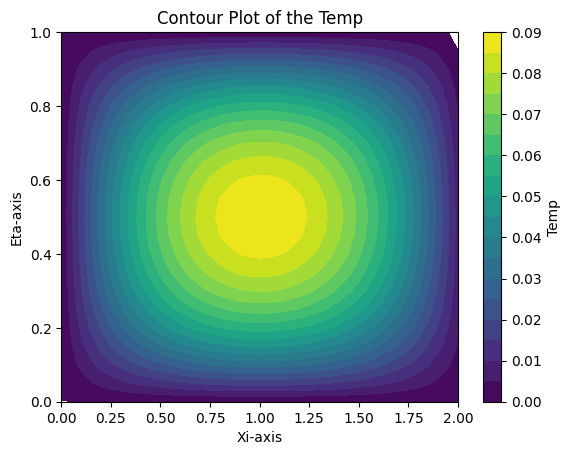

In [37]:
zs=jnp.linspace(0,Lz,Nx+1)
ns=jnp.linspace(0,Ln,Ny+1)
X,Y=np.meshgrid(zs,ns)

plt.figure(6)
plot_contour(zs,ns,T)

# plt.figure(7)
# plt.contourf(X,Y,T_true,levels=25)
# plt.xlabel('Xi-axis')
# plt.ylabel('Eta-axis')
# plt.colorbar(label='Temp')

loss=Loss_jax(k)
# plt.figure(8)
# Z=np.zeros((Ny+1,Nx+1))
# c=0
# for j in range(Ny+1):
#     for i in range(Nx+1):
#         Z[j,i]=loss[c]
#         c+=1
# plt.contourf(X, Y, Z,levels=20)

# plt.xlabel('Xi-axis')
# plt.ylabel('Eta-axis')
# plt.colorbar(label='Temp')
# plt.title('Contour Plot of the Temp Difference Squared')
# plt.savefig("Loss.svg")

#Compute Error Norm
print("Loss",loss)

In [38]:
#part vi
k=0.7
#set the intial alpha
alpha=.01
dlossdk=jax.grad(Loss_jax)
# print(dlossdk(k))
iters_num=49
rs=np.zeros(iters_num)

for i in range(iters_num):

    k_new=k-alpha*dlossdk(k)
    r=k_new-k
    rs[i]=r
    print("iteration",i,"k=",k,"K new",k_new,"Loss k",dlossdk(k),"residual",r)

    #change the alpha based on the residual, make it one order of magn lower than the res
    alpha=abs(r)/10
    k=k_new
    
    


iteration 0 k= 0.7 K new 0.6797321521382574 Loss k 2.026784786174251 residual -0.020267847861742516
iteration 1 k= 0.6797321521382574 K new 0.6757166797589534 Loss k 1.9812031384366053 residual -0.004015472379303997
iteration 2 k= 0.6757166797589534 K new 0.6749256813114815 Loss k 1.9698764497767083 residual -0.0007909984474719911
iteration 3 k= 0.6749256813114815 K new 0.6747700485888477 Loss k 1.967547763603326 residual -0.00015563272263374728
iteration 4 k= 0.6747700485888477 K new 0.6747394342978879 Loss k 1.9670857414678968 residual -3.0614290959851687e-05
iteration 5 k= 0.6747394342978879 K new 0.6747334124830554 Loss k 1.9669947085572324 residual -6.021814832446459e-06
iteration 6 k= 0.6747334124830554 K new 0.6747322280060505 Loss k 1.9669767966555651 residual -1.184477004922968e-06
iteration 7 k= 0.6747322280060505 K new 0.6747319950225893 Loss k 1.966973273202326 residual -2.3298346119027258e-07
iteration 8 k= 0.6747319950225893 K new 0.6747319491953813 Loss k 1.9669725801399

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-2.02678479e-02 -4.01547238e-03 -7.90998447e-04 -1.55632723e-04
 -3.06142910e-05 -6.02181483e-06 -1.18447700e-06 -2.32983461e-07
 -4.58272080e-08 -9.01408559e-09 -1.77304582e-09 -3.48753249e-10
 -6.85987933e-11 -1.34932066e-11 -2.65409916e-12 -5.22026866e-13
 -1.02695630e-13 -2.02060590e-14 -3.99680289e-15 -7.77156117e-16
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


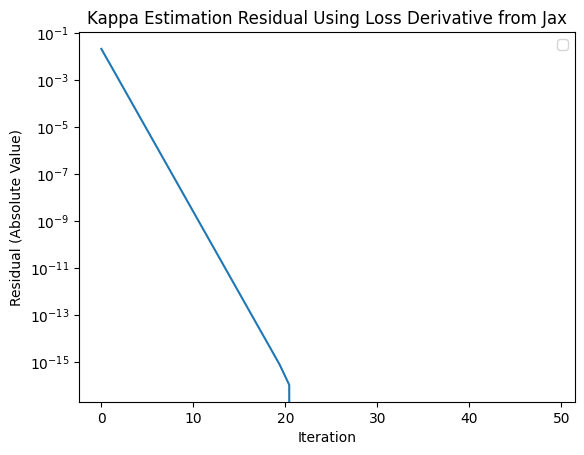

In [39]:
plt.figure(9)
print(rs)
iters=np.linspace(0,iters_num,iters_num)
plt.plot(iters,abs(rs))
plt.xlabel("Iteration")
plt.ylabel("Residual (Absolute Value)")
plt.yscale('log')
# plt.yscale("log")
plt.title("Kappa Estimation Residual Using Loss Derivative from Jax")
plt.legend()
plt.savefig("prob_vi.svg")